In [5]:
import zipfile
from IPython.display import display

from PIL import Image, ImageDraw
from kraken import binarization, pageseg
from time import sleep
# im = Image.open('foo.png')
# bw_im = binarization.nlbin(im)
# seg_data = pageseg.segment(bw_im)
import pytesseract
import cv2
import matplotlib.pyplot as plt 
%matplotlib inline
import numpy as np

# loading the face detection classifier
# face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')
NEWSPAPER = list()
# prepeocessing: {'img':{'words':'str', 'faces':[]}}
def keyword_in_newspaper(keyword, img):
    drawing_obj = ImageDraw.Draw(img)
    bounding_box = pageseg.segment(binarization.nlbin(img), black_colseps=True)['boxes']
    for box in bounding_box:
        drawing_obj.rectangle(box, fill = None, outline ='red')
    display(img)

def extract_words(img):
    words = ''
    bounding_box = pageseg.segment(binarization.nlbin(img, threshold=0.2), black_colseps=True)['boxes']
    for box in bounding_box:
        cur_img = img.crop(box)
        words += pytesseract.image_to_string(cur_img)
    return words

def extract_faces(img):
    faces = list()
    grey = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    face_cascade = cv2.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')
    face_box = face_cascade.detectMultiScale(grey, scaleFactor=1.3, minNeighbors=5, minSize=(30,30))
    for box in face_box:
        # cv2.rectangle(img, (face[0], face[1]), (face[0]+face[2], face[1]+face[3]), color=(255,255,0), thickness=3)
        # display(img)
        # plt.imshow(img)
        # cv2.imwrite('tt_1.33.png', img)
        faces.append(img[box[1]:box[1]+box[3],box[0]:box[0]+box[2]])
    return faces

def pre_porcessing():
    with zipfile.ZipFile('readonly/images.zip', 'r') as myzip:
        for file_obj in myzip.infolist():
            filename = file_obj.filename
            with myzip.open(file_obj) as file:
                pil_img = Image.open(file).convert('RGB')
                opencv_img = np.array(pil_img) # RGB
                words = extract_words(pil_img.convert('L'))
                faces = extract_faces(opencv_img)
            NEWSPAPER.append({'filename':filename, 'words':words, 'faces':faces})
                

# img = Image.open('readonly/small_img/a-0.png').convert('L')
# keyword_in_newspaper('ad',img)
# img = Image.open('readonly/two_col.png').convert('L')
# get_words(img)
# img = cv2.imread('readonly/images/a-1.png')
# grey = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# faces = extract_faces(grey)
# for face in faces:
#     plt.imshow(face)
pre_porcessing()

In [64]:
len(NEWSPAPER)

14

5 5
5 145
5 285


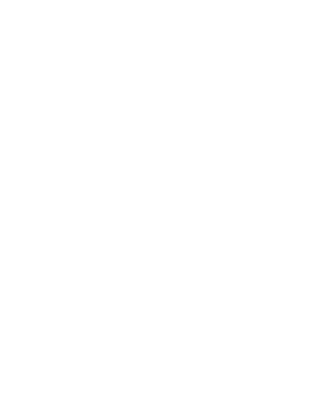

In [36]:
from PIL import ImageDraw, ImageFont
fnt = ImageFont.truetype("readonly/fanwood-webfont.ttf", 75)
THUMBNAIL_SIZE = (60,80)
TEXT_FONT = 50
PADDING = 5
CONTACT_SHEET = Image.new('RGB', (THUMBNAIL_SIZE[0]*5+10,5), color=(255,255,255))
def generate_contact_sheet(keyword):
    global CONTACT_SHEET
    result = [page for page in NEWSPAPER if keyword.lower() in page['words'].lower()]
    cursor_x = 5
    cursor_y = CONTACT_SHEET.size[1]
    times = 0
    for page in result:
        filename = page['filename']
        CONTACT_SHEET = Image.new('RGB', (CONTACT_SHEET.size[0], CONTACT_SHEET.size[1]+TEXT_FONT+PADDING), color=(255,255,255))
        print(cursor_x, cursor_y)
        ImageDraw.Draw(CONTACT_SHEET).text((cursor_x, cursor_y), f'Results found in file {filename}', fill='red', font=fnt)
        cursor_y = CONTACT_SHEET.size[1]
        if len(page['faces'])>0:
            rel_x=0
            rel_y=0
            face_sheet = Image.new('RGB', (THUMBNAIL_SIZE[0]*5,THUMBNAIL_SIZE[1]))
            for face in page['faces']:
                face = Image.fromarray(face) # convert opencv image to pil image
                face.thumbnail(THUMBNAIL_SIZE)
                face_sheet.paste(face, (rel_x, rel_y))
                rel_x = (rel_x + THUMBNAIL_SIZE[0]) % (THUMBNAIL_SIZE[0]*5)
                if rel_x == 0: rel_y += THUMBNAIL_SIZE[1]
            # paste face_sheet to CONTACT_SHEET
            CONTACT_SHEET = Image.new('RGB', (CONTACT_SHEET.size[0], CONTACT_SHEET.size[1]+face_sheet.size[1]+PADDING), color=(255,255,255))
            CONTACT_SHEET.paste(face_sheet, (cursor_x, cursor_y))
            cursor_y = CONTACT_SHEET.size[1]
        else:
            CONTACT_SHEET = Image.new('RGB', (CONTACT_SHEET.size[0], CONTACT_SHEET.size[1]+TEXT_FONT+PADDING), color=(255,255,255))
            ImageDraw.Draw(CONTACT_SHEET).text((cursor_x, cursor_y), 'But there were no faces in that file!')
            cursor_y = CONTACT_SHEET.size[1]
        times += 1
        if times > 2: break
    # display(CONTACT_SHEET)
    return CONTACT_SHEET

contact_sheet = generate_contact_sheet('Mark')
display(contact_sheet)
# len(result)
# [page['filename'] for page in result]

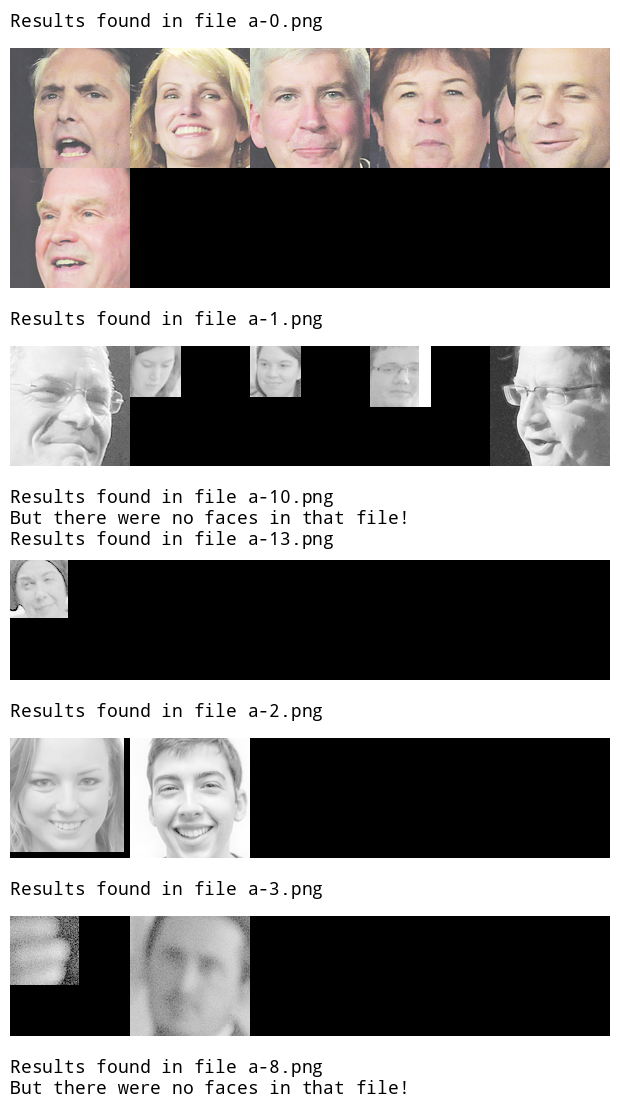

Results found in file a-0.png
<class 'PIL.Image.Image'>
Results found in file a-1.png
<class 'PIL.Image.Image'>
Results found in file a-10.png
But there were no faces in that file!
Results found in file a-13.png
<class 'PIL.Image.Image'>
Results found in file a-2.png
<class 'PIL.Image.Image'>
Results found in file a-3.png
<class 'PIL.Image.Image'>
Results found in file a-8.png
But there were no faces in that file!


In [136]:
# print(result[0]['filename'])
# for face in result[0]['faces']:
#     face = Image.fromarray(face)
#     display(face)
from PIL import ImageDraw, ImageFont
TEXT_FONT = 18
# fnt = ImageFont.truetype("readonly/fanwood-webfont.ttf", 20)
fnt = ImageFont.truetype("readonly/DroidSansMono.ttf", 18)
THUMBNAIL_SIZE = (120,120)
PADDING = 10

def generate_contact_sheet(keyword):
    result = [page for page in NEWSPAPER if keyword in page['words']]
    content_to_draw = list()
    content_to_draw_height = list()
    for page in result:
        filename = page['filename']
        string1 = f'Results found in file {filename}'
        face_sheet = None
        string2 = None
        if len(page['faces'])>0:
            rel_x = 0
            rel_y = 0
            num_row = len(page['faces'])//5 if len(page['faces'])%5 == 0 else len(page['faces'])//5 + 1
            face_sheet = Image.new('RGB', (THUMBNAIL_SIZE[0]*5,THUMBNAIL_SIZE[1]*num_row))
            for face in page['faces']:
                # print(rel_x, rel_y)
                face = Image.fromarray(face) # convert opencv image to pil image
                face.thumbnail(THUMBNAIL_SIZE)
                face_sheet.paste(face, (rel_x, rel_y))
                rel_x = (rel_x + THUMBNAIL_SIZE[0]) % (THUMBNAIL_SIZE[0]*5)
                if rel_x == 0: rel_y += THUMBNAIL_SIZE[1]
        else:
            string2 = 'But there were no faces in that file!'
        for item in [string1, string2, face_sheet]:
            if not item is None:
                if len(content_to_draw) > 0 and isinstance(item, str) and isinstance(content_to_draw[-1], str):
                    content_to_draw[-1] += ('\n' + item)
                    content_to_draw_height[-1] += TEXT_FONT
                else:
                    content_to_draw.append(item)
                    content_to_draw_height.append(TEXT_FONT if isinstance(item, str) else item.size[1])
    # for content in content_to_draw:
    #     if isinstance(content, Image.Image):
    #         display(content)
    # draw contact sheet
    contact_sheet_size = (THUMBNAIL_SIZE[0]*5 + PADDING*2, sum(content_to_draw_height) + len(content_to_draw)*PADDING*2)

    contact_sheet = Image.new('RGB', contact_sheet_size, color='white')
    cursor_x = PADDING
    cursor_y = PADDING
    for i in range(len(content_to_draw)):
        if isinstance(content_to_draw[i], str):
            ImageDraw.Draw(contact_sheet).text((cursor_x, cursor_y), content_to_draw[i], font=fnt, fill='black')
            # pass
            # try:
            #     contact_sheet.paste(content_to_draw[i], cursor)
            # except:
            #     print(i)
        else:
            # pass
            # print(i, content_to_draw[i].mode)
            # display(content_to_draw[i])
            try:
                contact_sheet.paste(content_to_draw[i], (cursor_x,cursor_y))
            except Exception as e:
                print(e)
        
        cursor_y += (content_to_draw_height[i] + PADDING*2)
    # print(cursor)
    # contact_sheet.paste(content_to_draw[1], cursor)
    # print(cursor)
    # cursor[1] = cursor[1] + content_to_draw_height[1]
    # # print(cursor, content_to_draw_height)
    # print(cursor)
    # contact_sheet.paste(content_to_draw[3], cursor)
    # cursor[1] += content_to_draw_height[3]
    display(contact_sheet)
    return content_to_draw, content_to_draw_height



content_to_draw, content_to_draw_height =  generate_contact_sheet('Mark')
for item in content_to_draw:
    if isinstance(item, str):
        print(item)
    else:
        print(type(item))

In [38]:
THUMBNAIL_SIZE = (80,80)
rel_x = 0
rel_y = 0
# face_sheet = Image.new('RGB', (THUMBNAIL_SIZE[0]*5,THUMBNAIL_SIZE[1]))
face_sheet = Image.new('RGB', (THUMBNAIL_SIZE[0]*5,THUMBNAIL_SIZE[1]*(len(page['faces'])//5+1)))
for face in result[0]['faces']:
    print(rel_x, rel_y)
    face = Image.fromarray(face) # convert opencv image to pil image
    face.thumbnail(THUMBNAIL_SIZE)
    face_sheet.paste(face, (rel_x, rel_y))
    rel_x = (rel_x + THUMBNAIL_SIZE[0]) % (THUMBNAIL_SIZE[0]*5)
    if rel_x == 0: rel_y += THUMBNAIL_SIZE[1]

display(face_sheet)

NameError: name 'page' is not defined

(520, 1000) RGB
(500, 200) RGB


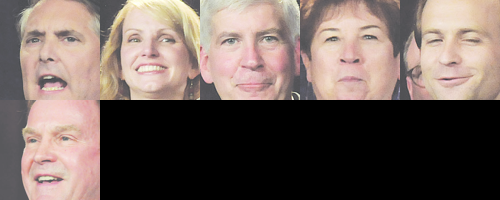

(500, 100) RGB


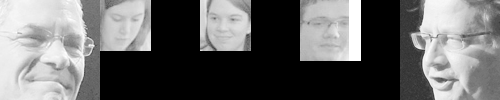

(500, 100) RGB


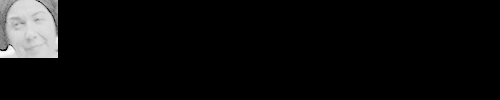

(500, 100) RGB


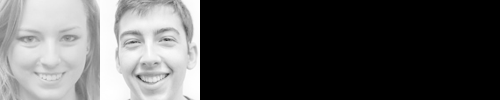

(500, 100) RGB


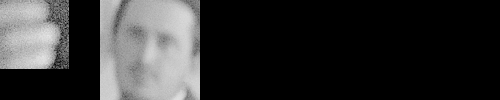

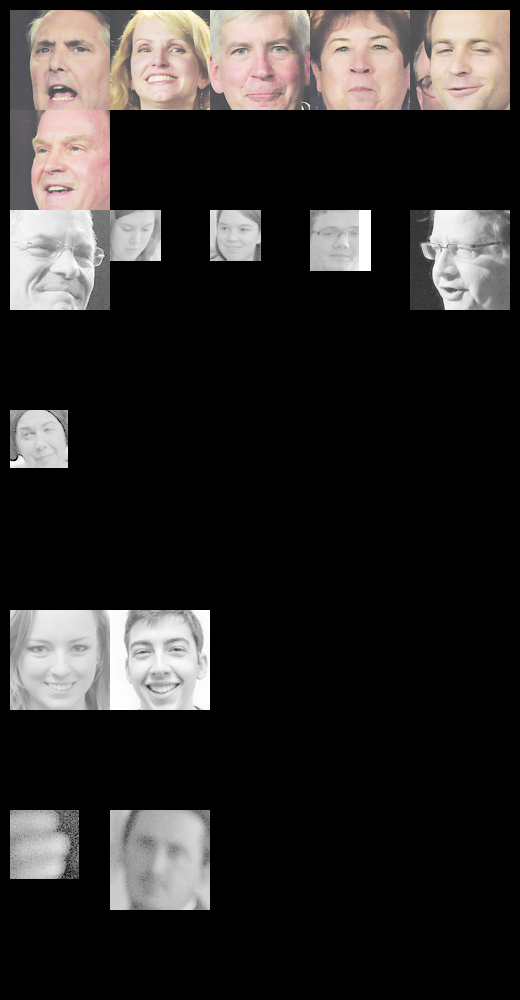

In [108]:
cursor_x = PADDING
cursor_y = PADDING
face_sheet = [content for content in content_to_draw if isinstance(content, Image.Image)]
contact_sheet_size = (THUMBNAIL_SIZE[0]*5+PADDING*2, len(face_sheet)*THUMBNAIL_SIZE[1]*2)
contact_sheet = Image.new('RGB',contact_sheet_size)
print(contact_sheet.size, contact_sheet.mode)
for face in face_sheet:
    try:
        print(face.size, face.mode)
        display(face)
        contact_sheet.paste(face, (cursor_x, cursor_y))
        cursor_y += THUMBNAIL_SIZE[1]*2
    except Exception as e:
        print(e)
    # cursor[1] += THUMBNAIL_SIZE[1]*
    # break

display(contact_sheet)

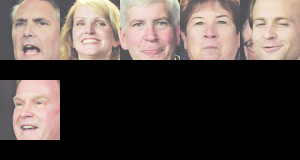

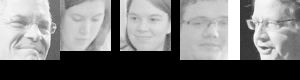

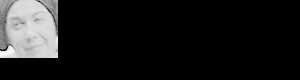

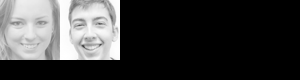

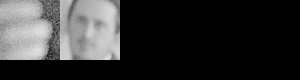

In [95]:
for face in face_sheet:
    display(face)

In [44]:
# type(face_sheet)
# isinstance(face_sheet, Image)
words = 'abc'
# type(words)
isinstance(words, str)

True

In [ ]:
import PIL
img = Image.open('readonly/small_img/a-0.png')
img.thumbnail((1000,1000))
# print(img.size)
ImageDraw.Draw(img).text((10, 10), 'Results found in file Results found in file Results found in file Results found in file Results found in file Results found in file\n Results found in file', fill='red')
display(img)

In [1]:
from kraken import pageseg, binarization
import pytesseract
from PIL import Image

def extract_words(img):
    words = ''
    bounding_box = pageseg.segment(binarization.nlbin(img, threshold=0.2), black_colseps=True, scale=1000)['boxes']
    print(len(bounding_box))
    for box in bounding_box:
        cur_img = img.crop(box)
        words += pytesseract.image_to_string(cur_img)
    return words

words = extract_words(Image.open('readonly/images/a-13.png'))
words

1


'THE VISUAL STATEMENT:HALLOWEEN IN NEW YORK\nBY VIRGINIA LOZANO\n\n \n\nhad the pleasure of attending one of American photographer Mary Ellen\nMark’s photography workshops last week in New York City. Like much of Mary\nEllen’s work, we focused on street photography of children and dogs. It was an envi-\nronment where we had to find moments in Halloween events that were more than\njust the costumes or adorable subjects. Moments that told stories of where we were,\nand how the neighborhoods within Queens and Brooklyn are composed of both rich\nand poor areas living right next to each other. To put it simply, it was what Mary\nEllen, who has won three Robert F. Kennedy Journalism Awards, described as just\n“American.”\n\n \n\x0c'

In [ ]:
from PIL import Image
from kraken import binarization
img = Image.open('readonly/images/a-13.png')
# display(img.convert('1'))
# img.mode
img = binarization.nlbin(img,threshold=0.2)
display(img)

In [4]:
'Mark' in 'THE VISUAL STATEMENT:HALLOWEEN IN NEW YORK\nBY VIRGINIA LOZANO\n\n \n\nhad the pleasure of attending one of American photographer Mary Ellen\nMark’s photography workshops last week in New York City. Like much of Mary\nEllen’s work, we focused on street photography of children and dogs. It was an envi-\nronment where we had to find moments in Halloween events that were more than\njust the costumes or adorable subjects. Moments that told stories of where we were,\nand how the neighborhoods within Queens and Brooklyn are composed of both rich\nand poor areas living right next to each other. To put it simply, it was what Mary\nEllen, who has won three Robert F. Kennedy Journalism Awards, described as just\n“American.”\n\n \n\x0c'

True

In [10]:
a = 123
def good():
    global a
    a += 1
    print(a)

good()

124


In [ ]:
Image.new('RGB', )